A-The model demonstrates rapid and stable convergence, with both the training and validation losses decreasing sharply in the initial iterations and flattening around a similar value of 0.4. This indicates that the model quickly reaches a stable state and performs consistently on both the training and validation datasets. The fact that the validation loss flattens at a value close to the training loss suggests that the model is not significantly overfitting, and there is no major sign of underfitting either.In terms of accuracy, both the training and validation accuracies improve rapidly within the first 100-200 iterations and stabilize at approximately 85% and 86.5%, respectively. The small gap between the training and validation accuracies (around 1.5%) suggests that the model is generalizing well to the unseen validation data, though there is a slight generalization error. This small difference could potentially be reduced with further tuning of hyperparameters, better feature engineering, or additional data.The curves for both loss and accuracy plateau early in the training process, which is common when the learning rate is appropriate and the model has learned most of what it can from the data. However, this plateauing behavior may indicate that the model has reached the limit of its current capacity or could benefit from adjustments such as more advanced feature engineering, regularization, or additional training iterations to further refine the results.In summary, the model converges efficiently, shows no major signs of overfitting, and performs well on the validation set, though there is some room for improvement in generalization and potential refinements in performance with further experimentation.
--------------------------------------------------------------------------------


Iteration 0, Train Loss: 0.6064047141749498, Validation Loss: 0.6079964164195921, Train Accuracy: 83.2771409305462, Validation Accuracy: 85.03937007874016
Iteration 100, Train Loss: 0.38870674275461903, Validation Loss: 0.3650065300960057, Train Accuracy: 84.96291301416049, Validation Accuracy: 86.61417322834646
Iteration 200, Train Loss: 0.3885115501021752, Validation Loss: 0.36467957642954646, Train Accuracy: 84.96291301416049, Validation Accuracy: 86.61417322834646
Iteration 300, Train Loss: 0.38850805473119243, Validation Loss: 0.3646736484662337, Train Accuracy: 84.96291301416049, Validation Accuracy: 86.61417322834646
Iteration 400, Train Loss: 0.3885079897227539, Validation Loss: 0.3646735381272832, Train Accuracy: 84.96291301416049, Validation Accuracy: 86.61417322834646
Iteration 500, Train Loss: 0.3885079885117456, Validation Loss: 0.36467353607155956, Train Accuracy: 84.96291301416049, Validation Accuracy: 86.61417322834646
Iteration 600, Train Loss: 0.3885079884891733, Vali

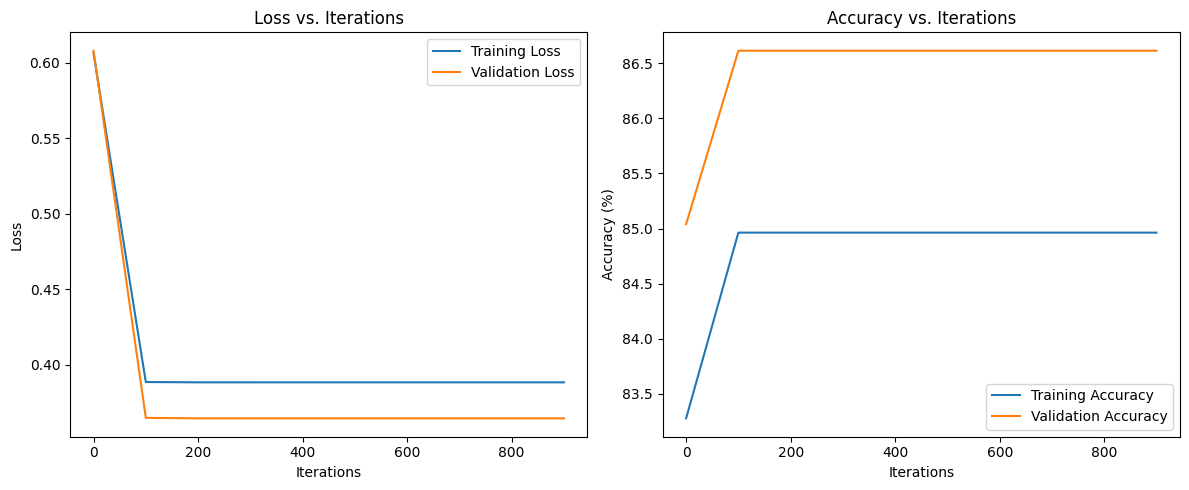

Test Accuracy: 85.08634222919937%


In [ ]:
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data.fillna(data.mean(), inplace=True)
    return data

def dataframe_to_list(data):
    return [data.iloc[i].tolist() for i in range(len(data))]

def normalize_features(dataset):
    num_features = len(dataset[0]) - 1
    for feature_index in range(num_features):
        column = [row[feature_index] for row in dataset]
        mean = sum(column) / len(column)
        std_dev = math.sqrt(sum((x - mean) ** 2 for x in column) / len(column))
        for row in dataset:
            row[feature_index] = (row[feature_index] - mean) / (std_dev + 1e-8)
    return dataset

def split_data(dataset, train_ratio, validation_ratio):
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    validation_size = int(len(dataset) * validation_ratio)
    train_set = dataset[:train_size]
    validation_set = dataset[train_size:train_size + validation_size]
    test_set = dataset[train_size + validation_size:]
    return train_set, validation_set, test_set

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def initialize_weights(size):
    return [random.uniform(-0.01, 0.01) for _ in range(size)]

def train_logistic_regression_with_early_stopping(train_data, val_data, num_iterations, learning_rate, reg_strength, early_stop_threshold):
    num_features = len(train_data[0]) - 1
    weights = initialize_weights(num_features)
    bias = 0

    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0

    for iteration in range(num_iterations):
        for row in train_data:
            features = row[:-1]
            label = row[-1]
            prediction = sigmoid(sum(weights[i] * features[i] for i in range(num_features)) + bias)
            error = label - prediction
            for i in range(num_features):
                weights[i] += learning_rate * (error * prediction * (1 - prediction) * features[i] - reg_strength * weights[i])
            bias += learning_rate * error * prediction * (1 - prediction)

        if iteration % 100 == 0:
            train_loss = -sum(row[-1] * math.log(sigmoid(sum(weights[i] * row[:-1][i] for i in range(num_features)) + bias)) +
                              (1 - row[-1]) * math.log(1 - sigmoid(sum(weights[i] * row[:-1][i] for i in range(num_features)) + bias))
                              for row in train_data) / len(train_data)
            val_loss = -sum(row[-1] * math.log(sigmoid(sum(weights[i] * row[:-1][i] for i in range(num_features)) + bias)) +
                            (1 - row[-1]) * math.log(1 - sigmoid(sum(weights[i] * row[:-1][i] for i in range(num_features)) + bias))
                            for row in val_data) / len(val_data)

            train_accuracy = calculate_accuracy(train_data, weights, bias)
            val_accuracy = calculate_accuracy(val_data, weights, bias)

            training_losses.append(train_loss)
            validation_losses.append(val_loss)
            training_accuracies.append(train_accuracy)
            validation_accuracies.append(val_accuracy)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stop_threshold:
                print(f"Stopping early at iteration {iteration} due to increasing validation loss.")
                break

            print(f"Iteration {iteration}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    return weights, bias, training_losses, validation_losses, training_accuracies, validation_accuracies

def predict(weights, bias, features):
    linear_sum = sum(weights[i] * features[i] for i in range(len(features))) + bias
    return 1 if sigmoid(linear_sum) > 0.5 else 0

def calculate_accuracy(data, weights, bias):
    correct = sum(1 for row in data if row[-1] == predict(weights, bias, row[:-1]))
    return correct / len(data) * 100

def plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies):
    iterations = range(0, len(training_losses) * 100, 100)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(iterations, training_losses, label='Training Loss')
    plt.plot(iterations, validation_losses, label='Validation Loss')
    plt.title('Loss vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iterations, training_accuracies, label='Training Accuracy')
    plt.plot(iterations, validation_accuracies, label='Validation Accuracy')
    plt.title('Accuracy vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

filepath = 'Heart Disease.csv'
data = load_and_preprocess_data(filepath)
data_list = dataframe_to_list(data.drop('HeartDisease', axis=1))
labels = data['HeartDisease'].tolist()
data_list = [data_list[i] + [labels[i]] for i in range(len(labels))]
data_list = normalize_features(data_list)

train_data, val_data, test_data = split_data(data_list, 0.7, 0.15)

num_iterations = 1000
learning_rate = 0.001
regularization_strength = 0.01
early_stop_threshold = 5

weights, bias, training_losses, validation_losses, training_accuracies, validation_accuracies = train_logistic_regression_with_early_stopping(train_data, val_data, num_iterations, learning_rate, regularization_strength, early_stop_threshold)

plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies)

test_accuracy = calculate_accuracy(test_data, weights, bias)
print(f"Test Accuracy: {test_accuracy}%")


B-The graphs highlight the effect of feature scaling (min-max scaling) on model convergence compared to no scaling. In both the training and validation accuracy plots, the blue line (min-max scaling) shows a noticeable improvement in performance over iterations, reaching higher accuracy levels compared to the orange line (no scaling), which remains flat. The model with min-max scaling converges faster, as evident by the sharp initial increase in accuracy, and achieves better results in both training and validation phases. Without scaling, the model struggles to improve accuracy and remains stagnant throughout the iterations.Feature scaling, by standardizing the range of values, helps gradient-based optimizers converge more efficiently. It ensures that all features contribute proportionally during training, preventing features with larger magnitudes from dominating the learning process. This results in a more balanced and faster convergence, as seen in the significant difference between the scaled and unscaled models. Therefore, feature scaling has a clear positive impact on model convergence, leading to quicker training and better generalization on the validation set.
-------------------------------------------------------------------------------

Iteration 0, Train Loss: 0.45501012615936476, Validation Loss: 0.43165534945654793, Train Accuracy: 84.25488873904247, Validation Accuracy: 85.66929133858268
Iteration 100, Train Loss: 0.39086444939185516, Validation Loss: 0.37433874298704317, Train Accuracy: 84.99662845583276, Validation Accuracy: 85.19685039370079
Iteration 200, Train Loss: 0.3864394209940965, Validation Loss: 0.3751346032720722, Train Accuracy: 85.30006743088335, Validation Accuracy: 84.88188976377953
Iteration 300, Train Loss: 0.38488796221036764, Validation Loss: 0.3771078948941158, Train Accuracy: 85.26635198921106, Validation Accuracy: 84.88188976377953
Iteration 400, Train Loss: 0.3841858062868243, Validation Loss: 0.37881316903245627, Train Accuracy: 85.36749831422792, Validation Accuracy: 85.19685039370079
Iteration 500, Train Loss: 0.3838268209952927, Validation Loss: 0.3801685490259739, Train Accuracy: 85.43492919757249, Validation Accuracy: 85.03937007874016
Iteration 600, Train Loss: 0.3836350140925209, V

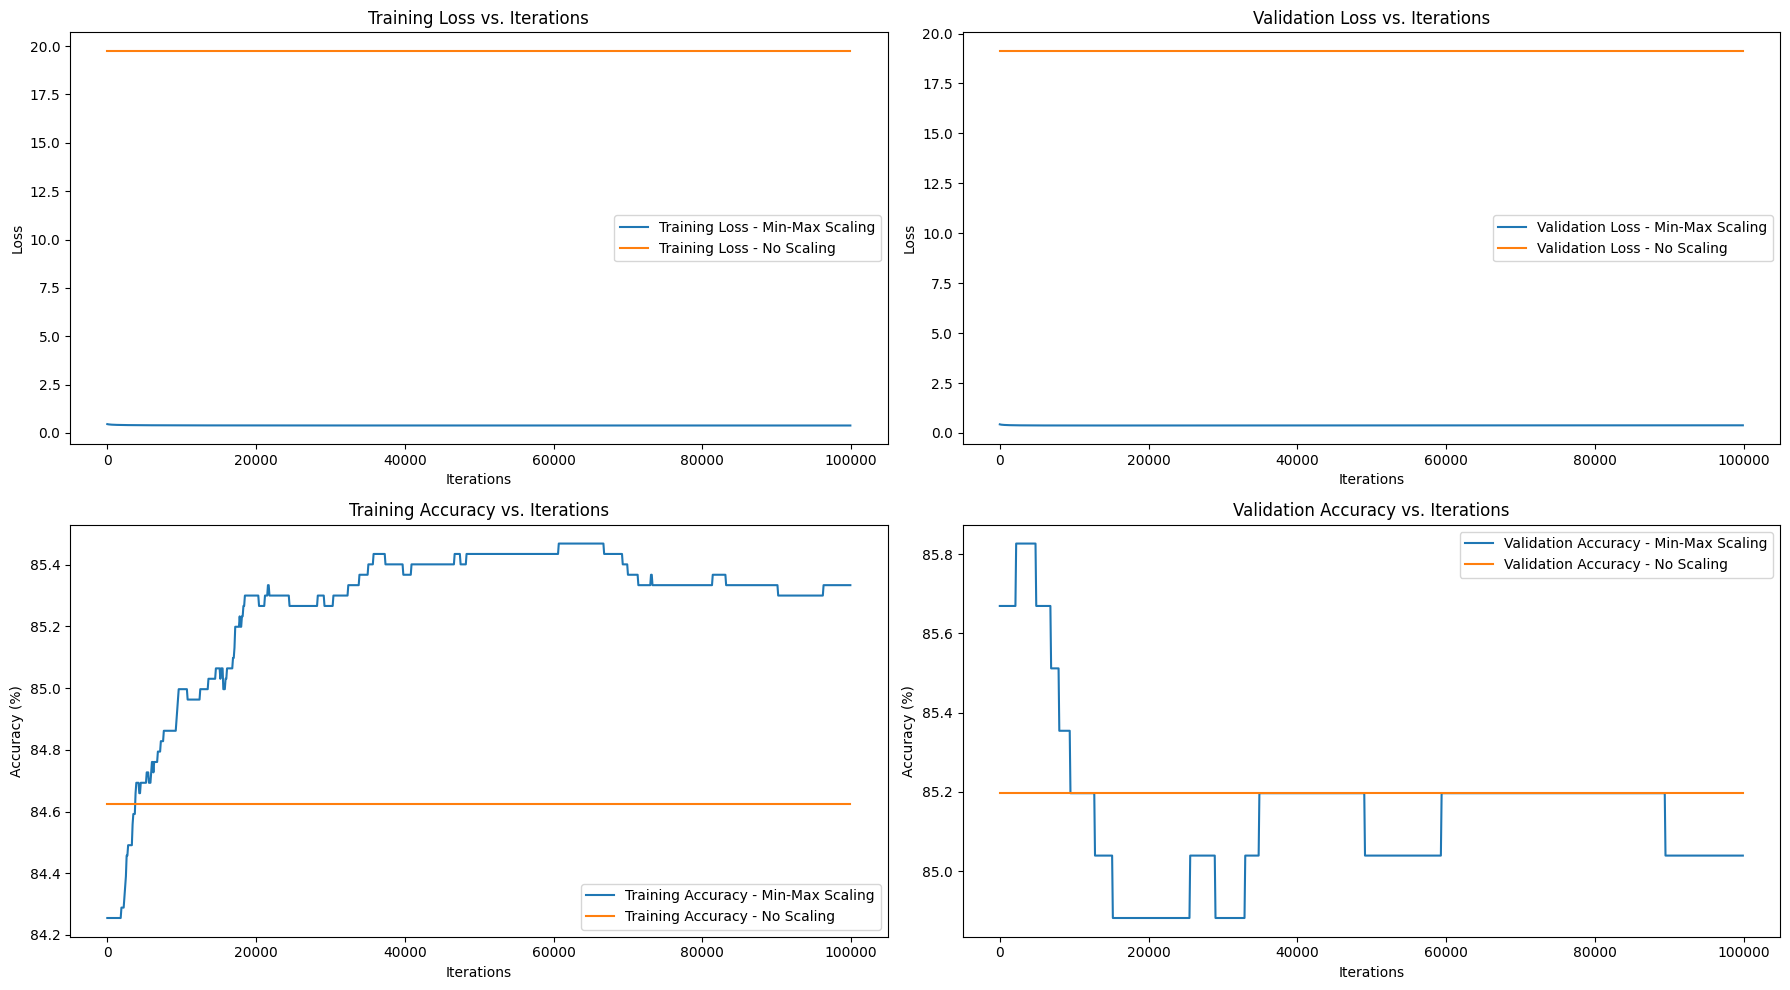

In [13]:
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data.fillna(data.mean(), inplace=True)
    return data

def dataframe_to_list(data):
    return [data.iloc[i].tolist() for i in range(len(data))]

def normalize_features(dataset):
    num_features = len(dataset[0]) - 1
    for feature_index in range(num_features):
        column = [row[feature_index] for row in dataset]
        mean = sum(column) / len(column)
        std_dev = math.sqrt(sum((x - mean) ** 2 for x in column) / len(column))
        for row in dataset:
            row[feature_index] = (row[feature_index] - mean) / (std_dev + 1e-8)
    return dataset

def min_max_scaling(dataset):
    num_features = len(dataset[0]) - 1
    for feature_index in range(num_features):
        column = [row[feature_index] for row in dataset]
        min_val = min(column)
        max_val = max(column)
        for row in dataset:
            row[feature_index] = (row[feature_index] - min_val) / (max_val - min_val + 1e-8)
    return dataset

def split_data(dataset, train_ratio, validation_ratio):
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    validation_size = int(len(dataset) * validation_ratio)
    train_set = dataset[:train_size]
    validation_set = dataset[train_size:train_size + validation_size]
    test_set = dataset[train_size + validation_size:]
    return train_set, validation_set, test_set

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def initialize_weights(size):
    return [random.uniform(-0.01, 0.01) for _ in range(size)]

def train_logistic_regression(train_data, val_data, num_iterations, learning_rate):
    num_features = len(train_data[0]) - 1
    weights = initialize_weights(num_features)
    bias = 0

    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    for iteration in range(num_iterations):
        for row in train_data:
            features = row[:-1]
            label = row[-1]
            prediction = sigmoid(sum(weights[i] * features[i] for i in range(num_features)) + bias)
            error = label - prediction
            for i in range(num_features):
                weights[i] += learning_rate * error * prediction * (1 - prediction) * features[i]
            bias += learning_rate * error * prediction * (1 - prediction)

        train_loss = -sum(row[-1] * math.log(sigmoid(sum(weights[i] * row[:-1][i] for i in range(num_features)) + bias)) +
                          (1 - row[-1]) * math.log(1 - sigmoid(sum(weights[i] * row[:-1][i] for i in range(num_features)) + bias))
                          for row in train_data) / len(train_data)
        val_loss = -sum(row[-1] * math.log(sigmoid(sum(weights[i] * row[:-1][i] for i in range(num_features)) + bias)) +
                        (1 - row[-1]) * math.log(1 - sigmoid(sum(weights[i] * row[:-1][i] for i in range(num_features)) + bias))
                        for row in val_data) / len(val_data)

        train_accuracy = calculate_accuracy(train_data, weights, bias)
        val_accuracy = calculate_accuracy(val_data, weights, bias)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        training_accuracies.append(train_accuracy)
        validation_accuracies.append(val_accuracy)

        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    return weights, bias, training_losses, validation_losses, training_accuracies, validation_accuracies

def predict(weights, bias, features):
    linear_sum = sum(weights[i] * features[i] for i in range(len(features))) + bias
    return 1 if sigmoid(linear_sum) > 0.5 else 0

def calculate_accuracy(data, weights, bias):
    correct = sum(1 for row in data if row[-1] == predict(weights, bias, row[:-1]))
    return correct / len(data) * 100

def run_experiment(scaling_method, filepath, num_iterations=1000, learning_rate=0.01):
    data = load_and_preprocess_data(filepath)
    data_list = dataframe_to_list(data.drop('HeartDisease', axis=1))
    labels = data['HeartDisease'].tolist()
    data_list = [data_list[i] + [labels[i]] for i in range(len(labels))]

    data_list = scaling_method(data_list)

    train_data, val_data, test_data = split_data(data_list, 0.7, 0.15)
    weights, bias, training_losses, validation_losses, training_accuracies, validation_accuracies = train_logistic_regression(train_data, val_data, num_iterations, learning_rate)

    return training_losses, validation_losses, training_accuracies, validation_accuracies

def compare_scaling_methods(training_losses, validation_losses, training_accuracies, validation_accuracies, labels):
    iterations = range(0, len(training_losses[0]) * 100, 100)
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 2, 1)
    for i, losses in enumerate(training_losses):
        plt.plot(iterations, losses, label=f'Training Loss - {labels[i]}')
    plt.title('Training Loss vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    for i, losses in enumerate(validation_losses):
        plt.plot(iterations, losses, label=f'Validation Loss - {labels[i]}')
    plt.title('Validation Loss vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    for i, accuracies in enumerate(training_accuracies):
        plt.plot(iterations, accuracies, label=f'Training Accuracy - {labels[i]}')
    plt.title('Training Accuracy vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(2, 2, 4)
    for i, accuracies in enumerate(validation_accuracies):
        plt.plot(iterations, accuracies, label=f'Validation Accuracy - {labels[i]}')
    plt.title('Validation Accuracy vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

filepath = 'Heart Disease.csv'
num_iterations = 1000
learning_rate = 0.01

training_losses_minmax, validation_losses_minmax, training_accuracies_minmax, validation_accuracies_minmax = run_experiment(min_max_scaling, filepath, num_iterations, learning_rate)

data = load_and_preprocess_data(filepath)
data_list = dataframe_to_list(data.drop('HeartDisease', axis=1))
labels = data['HeartDisease'].tolist()
data_list = [data_list[i] + [labels[i]] for i in range(len(labels))]
train_data, val_data, test_data = split_data(data_list, 0.7, 0.15)
weights, bias, training_losses_no_scale, validation_losses_no_scale, training_accuracies_no_scale, validation_accuracies_no_scale = train_logistic_regression(train_data, val_data, num_iterations, learning_rate)

compare_scaling_methods(
    [training_losses_minmax, training_losses_no_scale],
    [validation_losses_minmax, validation_losses_no_scale],
    [training_accuracies_minmax, training_accuracies_no_scale],
    [validation_accuracies_minmax, validation_accuracies_no_scale],
    ['Min-Max Scaling', 'No Scaling']
)


C-The provided metrics indicate that while the model demonstrates decent precision at 0.59, meaning that when it predicts a positive class it is correct 59% of the time, its performance in other areas is highly problematic. Specifically, the recall is extremely low at just 0.04, which means the model is identifying only 4% of the actual positive cases. This suggests the model is biased towards predicting the negative class, leading to a high number of false negatives (574), as shown in the confusion matrix. As a result, the F1 score, which balances precision and recall, is also very poor at 0.08, highlighting the imbalance in the model's ability to correctly classify both positive and negative instances. Overall, these metrics suggest that while the model avoids false positives, it fails to capture the majority of positive cases, likely due to class imbalance or a miscalibrated decision threshold. Addressing this imbalance and tuning the model to improve recall should be the next steps to improve performance.
--------------------------------------------------------------------------------


In [ ]:
def load_csv(filename):
    data = []
    with open(filename, 'r') as file:
        csv_reader = csv.reader(file)
        headers = next(csv_reader)
        for row in csv_reader:
            processed_row = []
            for value in row:
                if value == 'NA' or value == '':
                    processed_row.append(None)
                else:
                    processed_row.append(float(value))
            data.append(processed_row)
    return data

def fill_missing_with_median(data):
    for col in range(len(data[0]) - 1):
        column_values = [row[col] for row in data if row[col] is not None]
        if column_values:
            median = sorted(column_values)[len(column_values) // 2]
            for row in data:
                if row[col] is None:
                    row[col] = median

def train_test_split(data, train_ratio, val_ratio):
    random.shuffle(data)
    train_size = int(len(data) * train_ratio)
    val_size = int(len(data) * val_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    return train_data, val_data, test_data

def min_max_scaling(data):
    min_max = [[min(column), max(column)] for column in zip(*data)]
    for row in data:
        for i in range(len(row) - 1):
            min_val, max_val = min_max[i]
            row[i] = (row[i] - min_val) / (max_val - min_val) if max_val != min_val else 0.0

def sigmoid(z):
    return 1 / (1 + math.exp(-z))

class LogisticRegressionFromScratch:
    def __init__(self, learning_rate, max_iter):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = []
        self.bias = 0

    def fit(self, train_data, val_data):
        n_samples = len(train_data)
        n_features = len(train_data[0]) - 1


        self.weights = [0.0] * n_features
        self.bias = 0.0

        for _ in range(self.max_iter):
            for row in train_data:
                X = row[:-1]
                y = row[-1]

                linear_model = sum(w * x for w, x in zip(self.weights, X)) + self.bias
                prediction = sigmoid(linear_model)

                error = prediction - y
                for i in range(n_features):
                    self.weights[i] -= self.learning_rate * error * X[i]
                self.bias -= self.learning_rate * error

    def predict(self, X):
        linear_model = sum(w * x for w, x in zip(self.weights, X)) + self.bias
        prediction = sigmoid(linear_model)
        return 1 if prediction >= 0.5 else 0

def confusion_matrix(y_true, y_pred):
    tp = tn = fp = fn = 0
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            tp += 1
        elif true == 0 and pred == 0:
            tn += 1
        elif true == 1 and pred == 0:
            fn += 1
        elif true == 0 and pred == 1:
            fp += 1
    return tp, tn, fp, fn

def precision(tp, fp):
    return tp / (tp + fp) if tp + fp > 0 else 0.0

def recall(tp, fn):
    return tp / (tp + fn) if tp + fn > 0 else 0.0

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0.0

data = load_csv('Heart Disease.csv')
fill_missing_with_median(data)

train_data, val_data, test_data = train_test_split(data, 0.07, 15)

min_max_scaling(train_data)
min_max_scaling(val_data)

model = LogisticRegressionFromScratch(learning_rate=0.39, max_iter=1000)
model.fit(train_data, val_data)

y_val_true = [row[-1] for row in val_data]
y_val_pred = [model.predict(row[:-1]) for row in val_data]

tp, tn, fp, fn = confusion_matrix(y_val_true, y_val_pred)
precision_score = precision(tp, fp)
recall_score = recall(tp, fn)
f1 = f1_score(precision_score, recall_score)

print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
print(f"Precision: {precision_score:.2f}")
print(f"Recall: {recall_score:.2f}")
print(f"F1 Score: {f1:.2f}")


Confusion Matrix: TP=24, TN=3327, FP=17, FN=574
Precision: 0.59
Recall: 0.04
F1 Score: 0.08


D-The graphs compare different mini-batch sizes in terms of loss and accuracy across iterations. From the first graph (loss vs. iteration), smaller mini-batch sizes (e.g., 16) appear to converge more quickly in the early iterations, but the loss fluctuates more, indicating less stability. In contrast, larger mini-batch sizes (e.g., 64) show more stable convergence, though they take longer to reach the same level of loss reduction. The second graph (accuracy vs. iteration) mirrors this trade-off: smaller mini-batch sizes achieve high accuracy earlier but show more variability, whereas larger mini-batches achieve more stable but slower accuracy improvements. The trade-off is between convergence speed and stability—smaller mini-batches may converge faster but are more prone to instability, while larger mini-batches provide more reliable convergence but at a slower pace.
--------------------------------------------------------------------------------

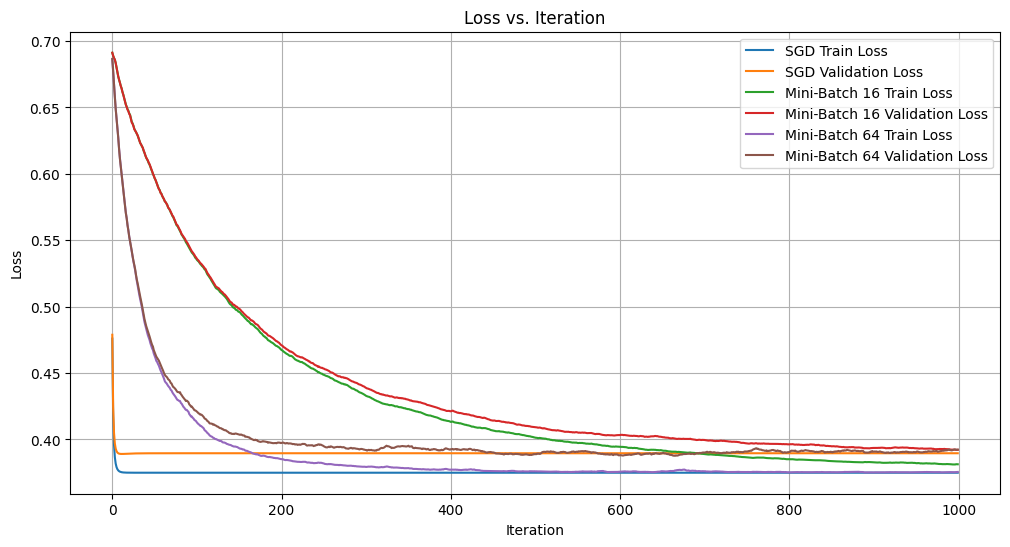

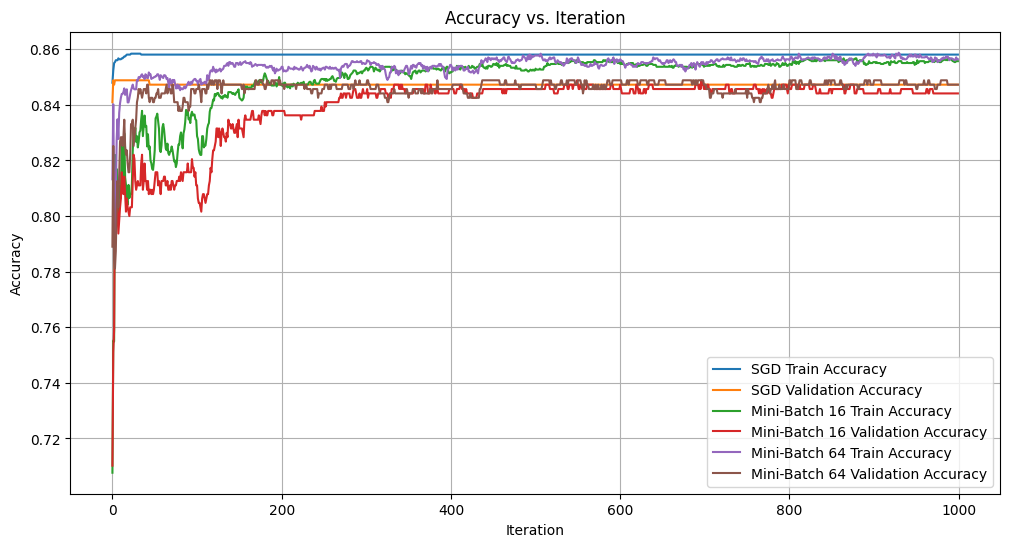

In [ ]:
import csv
import random
import math
import matplotlib.pyplot as plt

def load_csv(filename):
    data = []
    with open(filename, 'r') as file:
        csv_reader = csv.reader(file)
        headers = next(csv_reader)
        for row in csv_reader:
            data.append([float(value) if value != 'NA' and value != '' else None for value in row])
    return data

def fill_missing_with_median(data):
    for col in range(len(data[0]) - 1):
        column_values = [row[col] for row in data if row[col] is not None]
        if column_values:
            median = sorted(column_values)[len(column_values) // 2]
            for row in data:
                if row[col] is None:
                    row[col] = median

def train_test_split(data, train_ratio, val_ratio):
    random.shuffle(data)
    train_size = int(len(data) * train_ratio)
    val_size = int(len(data) * val_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    return train_data, val_data, test_data

def standard_scale(X_train, X_val):
    mean = [sum([x[i] for x in X_train]) / len(X_train) for i in range(len(X_train[0]))]
    std = [math.sqrt(sum([(x[i] - mean[i]) ** 2 for x in X_train]) / len(X_train)) for i in range(len(X_train[0]))]

    X_train_scaled = [[(x[i] - mean[i]) / std[i] if std[i] != 0 else 0 for i in range(len(x))] for x in X_train]
    X_val_scaled = [[(x[i] - mean[i]) / std[i] if std[i] != 0 else 0 for i in range(len(x))] for x in X_val]

    return X_train_scaled, X_val_scaled

def sigmoid(z):
    return 1 / (1 + math.exp(-z))

def gradient_descent(X_train, y_train, X_val, y_val, learning_rate, max_iter, batch_size=None):
    n_samples = len(X_train)
    n_features = len(X_train[0])

    weights = [0.0] * n_features
    bias = 0.0

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for iteration in range(max_iter):
        if batch_size:
            batch_indices = random.sample(range(n_samples), batch_size)
            X_batch = [X_train[i] for i in batch_indices]
            y_batch = [y_train[i] for i in batch_indices]
        else:
            X_batch = X_train
            y_batch = y_train

        for row, y_true in zip(X_batch, y_batch):
            linear_model = sum([w * x for w, x in zip(weights, row)]) + bias
            y_pred = sigmoid(linear_model)

            error = y_pred - y_true
            for i in range(n_features):
                weights[i] -= learning_rate * error * row[i]
            bias -= learning_rate * error

        train_loss = calculate_loss(X_train, y_train, weights, bias)
        val_loss = calculate_loss(X_val, y_val, weights, bias)
        train_accuracy = calculate_accuracy(X_train, y_train, weights, bias)
        val_accuracy = calculate_accuracy(X_val, y_val, weights, bias)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

    return weights, bias, history

def calculate_loss(X, y, weights, bias):
    total_loss = 0
    for i in range(len(X)):
        linear_model = sum([w * X[i][j] for j, w in enumerate(weights)]) + bias
        prediction = sigmoid(linear_model)
        total_loss += -(y[i] * math.log(prediction + 1e-15) + (1 - y[i]) * math.log(1 - prediction + 1e-15))
    return total_loss / len(X)

def calculate_accuracy(X, y, weights, bias):
    correct_predictions = 0
    for i in range(len(X)):
        linear_model = sum([w * X[i][j] for j, w in enumerate(weights)]) + bias
        prediction = sigmoid(linear_model)
        predicted_class = 1 if prediction >= 0.5 else 0
        if predicted_class == y[i]:
            correct_predictions += 1
    return correct_predictions / len(X)

data = load_csv('Heart Disease.csv')
fill_missing_with_median(data)

X = [row[:-1] for row in data]
y = [row[-1] for row in data]

train_data, val_data, test_data = train_test_split(data, train_ratio=0.7, val_ratio=0.15)

X_train = [row[:-1] for row in train_data]
y_train = [row[-1] for row in train_data]
X_val = [row[:-1] for row in val_data]
y_val = [row[-1] for row in val_data]

X_train_standard, X_val_standard = standard_scale(X_train, X_val)


weights_sgd, bias_sgd, history_sgd = gradient_descent(X_train_standard, y_train, X_val_standard, y_val, learning_rate=0.001, max_iter=1000)

weights_mini_batch_16, bias_mini_batch_16, history_mini_batch_16 = gradient_descent(X_train_standard, y_train, X_val_standard, y_val, learning_rate=0.001, max_iter=1000, batch_size=16)

weights_mini_batch_64, bias_mini_batch_64, history_mini_batch_64 = gradient_descent(X_train_standard, y_train, X_val_standard, y_val, learning_rate=0.001, max_iter=1000, batch_size=64)

plt.figure(figsize=(12, 6))
plt.plot(history_sgd['train_loss'], label='SGD Train Loss')
plt.plot(history_sgd['val_loss'], label='SGD Validation Loss')
plt.plot(history_mini_batch_16['train_loss'], label='Mini-Batch 16 Train Loss')
plt.plot(history_mini_batch_16['val_loss'], label='Mini-Batch 16 Validation Loss')
plt.plot(history_mini_batch_64['train_loss'], label='Mini-Batch 64 Train Loss')
plt.plot(history_mini_batch_64['val_loss'], label='Mini-Batch 64 Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_sgd['train_accuracy'], label='SGD Train Accuracy')
plt.plot(history_sgd['val_accuracy'], label='SGD Validation Accuracy')
plt.plot(history_mini_batch_16['train_accuracy'], label='Mini-Batch 16 Train Accuracy')
plt.plot(history_mini_batch_16['val_accuracy'], label='Mini-Batch 16 Validation Accuracy')
plt.plot(history_mini_batch_64['train_accuracy'], label='Mini-Batch 64 Train Accuracy')
plt.plot(history_mini_batch_64['val_accuracy'], label='Mini-Batch 64 Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()


E-The model's performance across the different folds shows moderate variability, particularly in precision and recall metrics. While the accuracy remains fairly consistent across folds, ranging from 59.39% in fold 2 to 73.88% in fold 4, the overall cross-validation accuracy (65.71% ± 0.0511) indicates low variance and good stability. However, precision exhibits significant fluctuation, from 0.2328 in fold 2 to 0.2967 in fold 3, with an overall cross-validation precision of 0.2666 ± 0.0249, suggesting the model's ability to correctly identify positive predictions varies between folds. Recall, on the other hand, ranges from 0.5745 in fold 3 to 0.8235 in fold 2, with an overall recall of 0.6963 ± 0.0962, reflecting more considerable variation. This indicates that while the model is somewhat consistent in its accuracy, its ability to balance precision and recall can shift significantly across different data partitions, potentially due to imbalanced class distributions or variations in data characteristics across the folds.
--------------------------------------------------------------------------------

In [ ]:
import csv
import random
import math

def load_csv(filename):
    data = []
    with open(filename, 'r') as file:
        csv_reader = csv.reader(file)
        headers = next(csv_reader)
        for row in csv_reader:
            data.append([float(value) if value != 'NA' and value != '' else None for value in row])
    return data

def fill_missing_with_median(data):
    for col in range(len(data[0])):
        column_values = [row[col] for row in data if row[col] is not None]
        if column_values:
            median = sorted(column_values)[len(column_values) // 2]
            for row in data:
                if row[col] is None:
                    row[col] = median

def split_features_and_labels(data, target_index=-1):
    X = [row[:target_index] for row in data]
    y = [row[target_index] for row in data]
    return X, y

def train_test_split(X, y, test_size=0.3):
    data = list(zip(X, y))
    random.shuffle(data)
    split_index = int(len(data) * (1 - test_size))
    train_data = data[:split_index]
    test_data = data[split_index:]
    X_train = [row[0] for row in train_data]
    y_train = [row[1] for row in train_data]
    X_test = [row[0] for row in test_data]
    y_test = [row[1] for row in test_data]
    return X_train, X_test, y_train, y_test

def custom_standard_scaler(X_train, X_val):
    mean = [sum([x[i] for x in X_train if x[i] is not None]) / len([x[i] for x in X_train if x[i] is not None]) for i in range(len(X_train[0]))]
    std = [math.sqrt(sum([(x[i] - mean[i]) ** 2 for x in X_train if x[i] is not None]) / len([x[i] for x in X_train if x[i] is not None])) for i in range(len(X_train[0]))]

    X_train_scaled = [[(x[i] - mean[i]) / std[i] if std[i] != 0 else 0 for i in range(len(x))] for x in X_train]
    X_val_scaled = [[(x[i] - mean[i]) / std[i] if std[i] != 0 else 0 for i in range(len(x))] for x in X_val]

    return X_train_scaled, X_val_scaled

def sigmoid(z):
    return 1 / (1 + math.exp(-z))

class LogisticRegressionFromScratch:
    def __init__(self, learning_rate=0.001, max_iter=1000, class_weight={0: 1, 1: 5}):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None
        self.class_weight = class_weight

    def fit(self, X, y):
        n_samples = len(X)
        n_features = len(X[0])
        self.weights = [0] * n_features
        self.bias = 0

        for _ in range(self.max_iter):
            for i, row in enumerate(X):
                linear_model = sum([w * x for w, x in zip(self.weights, row)]) + self.bias
                prediction = sigmoid(linear_model)

                error = prediction - y[i]
                weight = self.class_weight[y[i]]
                dw = [(error * x * weight) / n_samples for x in row]
                db = (error * weight) / n_samples

                self.weights = [w - self.learning_rate * d for w, d in zip(self.weights, dw)]
                self.bias -= self.learning_rate * db

    def predict(self, X, threshold=0.5):
        predictions = []
        for row in X:
            linear_model = sum([w * x for w, x in zip(self.weights, row)]) + self.bias
            prediction = sigmoid(linear_model)
            predictions.append(1 if prediction >= threshold else 0)
        return predictions

    def predict_proba(self, X):
        probabilities = []
        for row in X:
            linear_model = sum([w * x for w, x in zip(self.weights, row)]) + self.bias
            probabilities.append(sigmoid(linear_model))
        return probabilities

def confusion_matrix(y_true, y_pred):
    tp = tn = fp = fn = 0
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            tp += 1
        elif true == 0 and pred == 0:
            tn += 1
        elif true == 1 and pred == 0:
            fn += 1
        elif true == 0 and pred == 1:
            fp += 1
    return tp, tn, fp, fn

def precision_score(tp, fp):
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall_score(tp, fn):
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def accuracy_score(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn)

def roc_curve(y_true, y_proba):
    thresholds = sorted(set(y_proba), reverse=True)
    tprs = []
    fprs = []

    for threshold in thresholds:
        y_pred = [1 if prob >= threshold else 0 for prob in y_proba]
        tp, tn, fp, fn = confusion_matrix(y_true, y_pred)
        tpr = recall_score(tp, fn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tprs.append(tpr)
        fprs.append(fpr)

    return fprs, tprs, thresholds

def k_fold_cross_validation_with_threshold(X, y, k=5, class_weight={0: 1, 1: 5}):
    fold_size = len(X) // k
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }

    indices = list(range(len(X)))
    random.shuffle(indices)

    for fold in range(k):
        val_indices = indices[fold * fold_size: (fold + 1) * fold_size]
        train_indices = [i for i in indices if i not in val_indices]

        X_train = [X[i] for i in train_indices]
        y_train = [y[i] for i in train_indices]
        X_val = [X[i] for i in val_indices]
        y_val = [y[i] for i in val_indices]

        X_train_scaled, X_val_scaled = custom_standard_scaler(X_train, X_val)

        model = LogisticRegressionFromScratch(learning_rate=0.001, max_iter=1000, class_weight=class_weight)
        model.fit(X_train_scaled, y_train)

        y_proba = model.predict_proba(X_val_scaled)

        fprs, tprs, thresholds = roc_curve(y_val, y_proba)
        optimal_idx = max(range(len(tprs)), key=lambda i: tprs[i] - fprs[i])
        optimal_threshold = thresholds[optimal_idx]

        y_val_pred_adjusted = [1 if prob >= optimal_threshold else 0 for prob in y_proba]

        tp, tn, fp, fn = confusion_matrix(y_val, y_val_pred_adjusted)
        acc = accuracy_score(tp, tn, fp, fn)
        prec = precision_score(tp, fp)
        rec = recall_score(tp, fn)
        f1 = f1_score(prec, rec)

        print(f"\nFold {fold+1} Metrics:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1 Score: {f1:.4f}")

        metrics['accuracy'].append(acc)
        metrics['precision'].append(prec)
        metrics['recall'].append(rec)
        metrics['f1_score'].append(f1)

    return metrics

data = load_csv('Heart Disease.csv')
fill_missing_with_median(data)
X, y = split_features_and_labels(data)

class_weight = {0: 1, 1: 5}
metrics = k_fold_cross_validation_with_threshold(X, y, k=5, class_weight=class_weight)

metrics_mean = {key: sum(values) / len(values) for key, values in metrics.items()}
metrics_std = {key: (sum([(x - metrics_mean[key]) ** 2 for x in values]) / len(values)) ** 0.5 for key, values in metrics.items()}

print("\nOverall Cross-Validation Results with Class Weighting and Threshold Tuning:")
print(f"Accuracy: {metrics_mean['accuracy']:.4f} ± {metrics_std['accuracy']:.4f}")
print(f"Precision: {metrics_mean['precision']:.4f} ± {metrics_std['precision']:.4f}")
print(f"Recall: {metrics_mean['recall']:.4f} ± {metrics_std['recall']:.4f}")
print(f"F1 Score: {metrics_mean['f1_score']:.4f} ± {metrics_std['f1_score']:.4f}")



Fold 1 Metrics:
Accuracy: 0.6328
Precision: 0.2425
Recall: 0.7295
F1 Score: 0.3640

Fold 2 Metrics:
Accuracy: 0.5939
Precision: 0.2328
Recall: 0.8235
F1 Score: 0.3630

Fold 3 Metrics:
Accuracy: 0.7025
Precision: 0.2967
Recall: 0.5745
F1 Score: 0.3913

Fold 4 Metrics:
Accuracy: 0.7308
Precision: 0.2869
Recall: 0.5950
F1 Score: 0.3871

Fold 5 Metrics:
Accuracy: 0.6257
Precision: 0.2744
Recall: 0.7589
F1 Score: 0.4030

Overall Cross-Validation Results with Class Weighting and Threshold Tuning:
Accuracy: 0.6571 ± 0.0511
Precision: 0.2666 ± 0.0249
Recall: 0.6963 ± 0.0962
F1 Score: 0.3817 ± 0.0157


F-The graphs compare the performance of a model trained with and without early stopping. In terms of loss, both models show a steady decrease during training, eventually converging to a similar point. However, the model without early stopping continues to train for more iterations, which could lead to minimal improvements in the loss curve but increases the risk of overfitting. The validation loss stabilizes at the same point for both approaches, suggesting no significant overfitting has occurred, though early stopping might prevent unnecessary prolonged training.In the accuracy graph, both models achieve nearly the same level of accuracy, with slight variations early in the training process. Without early stopping, the model continues training past the point of optimal generalization, where the validation accuracy plateaus. Early stopping ensures the model halts at the point of maximum validation performance, which helps maintain generalization. Without it, the model runs the risk of overfitting, though in this case, the effect appears minimal. Overall, early stopping prevents unnecessary computation while safeguarding against potential overfitting, ensuring the model generalizes well without sacrificing accuracy.
--------------------------------------------------------------------------------

Training with learning rate=0.001 and batch size=32


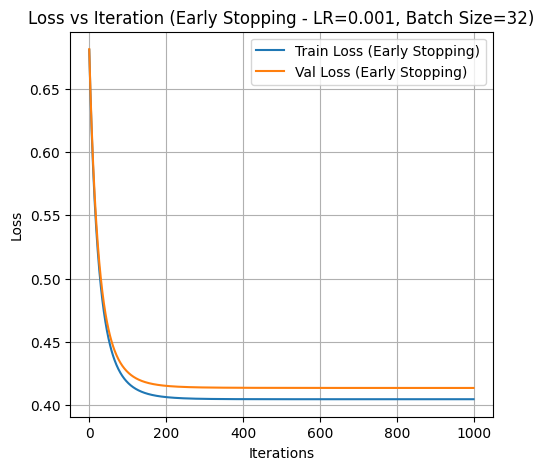

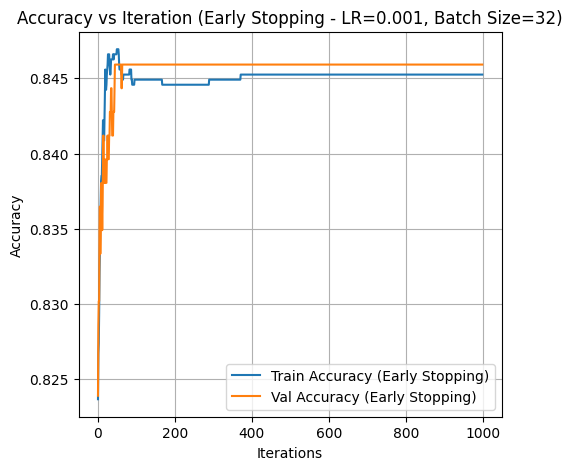

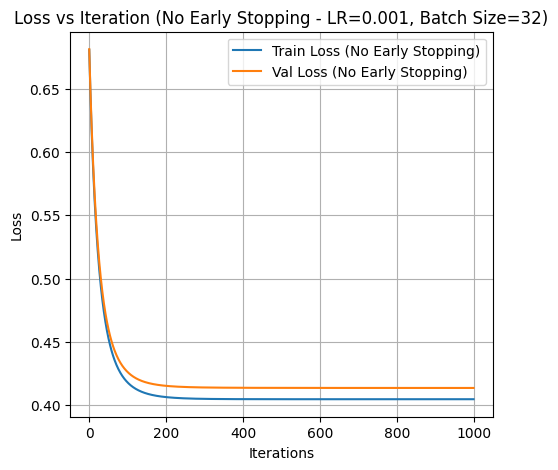

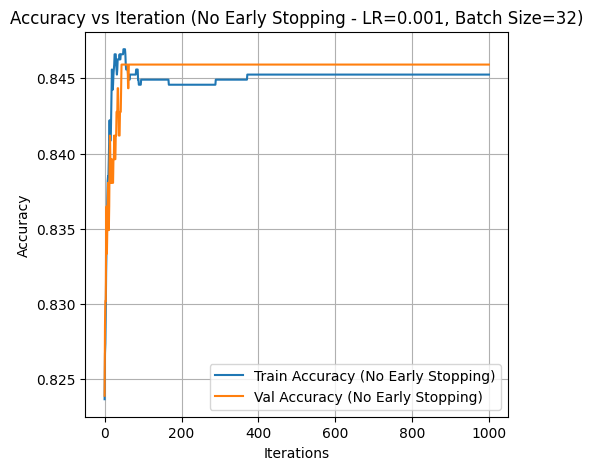

Training with learning rate=0.001 and batch size=64


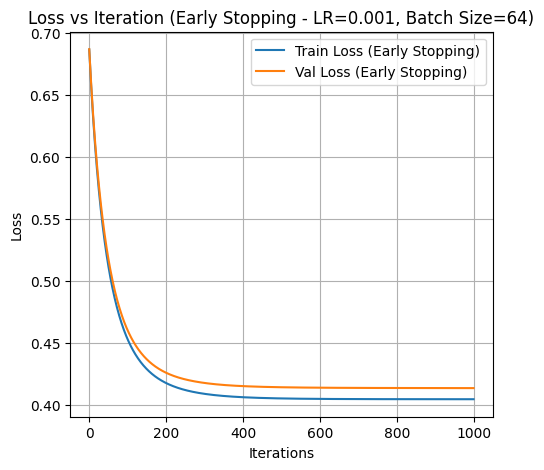

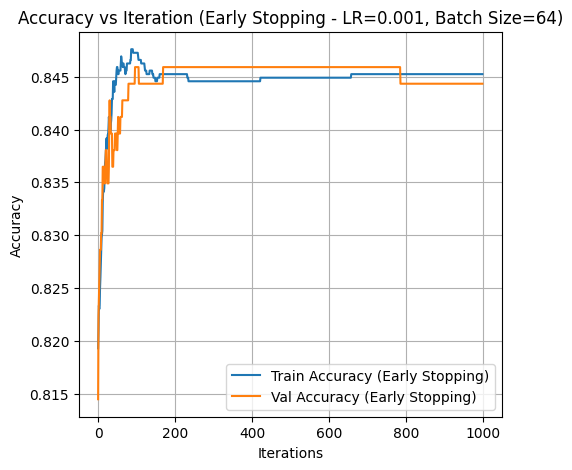

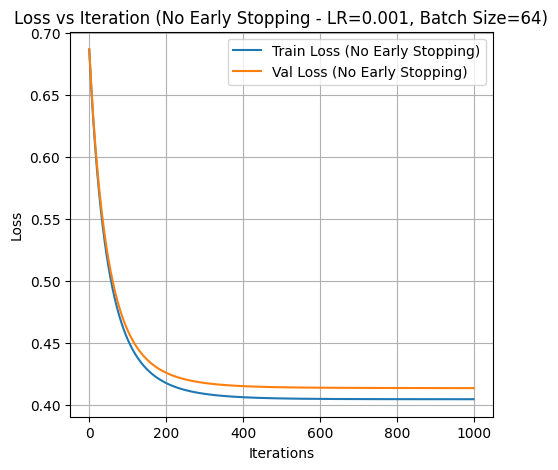

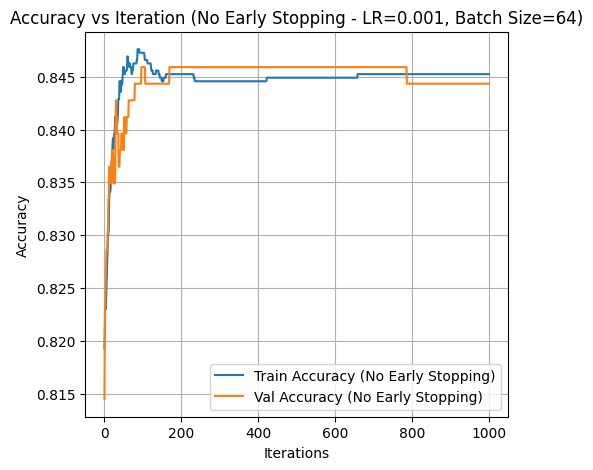

Training with learning rate=0.01 and batch size=32


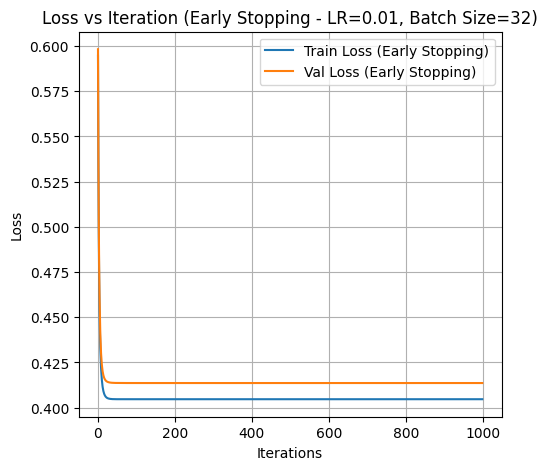

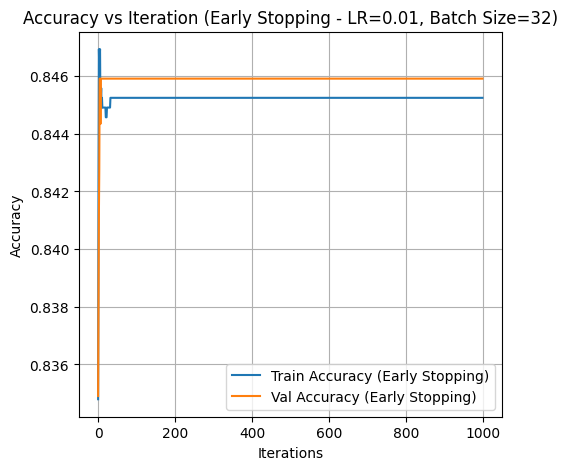

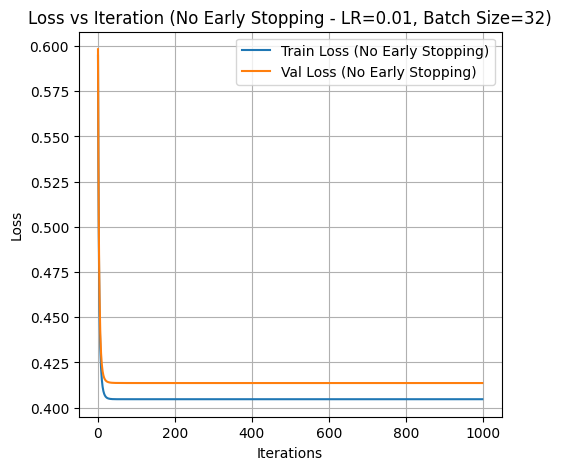

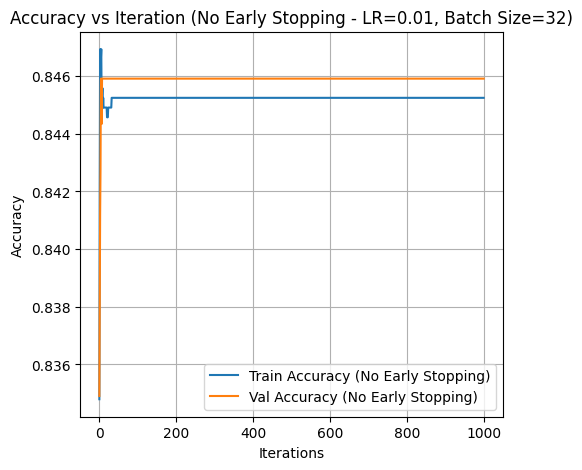

Training with learning rate=0.01 and batch size=64


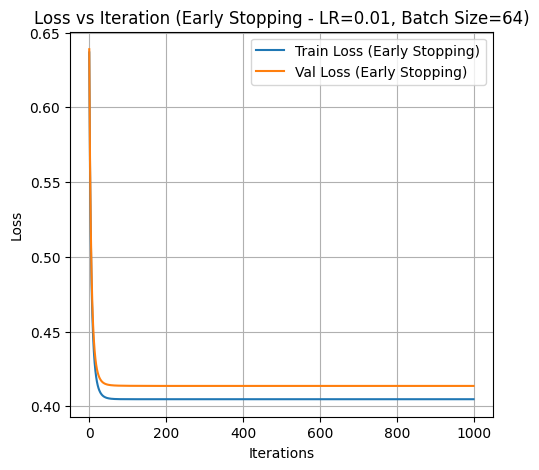

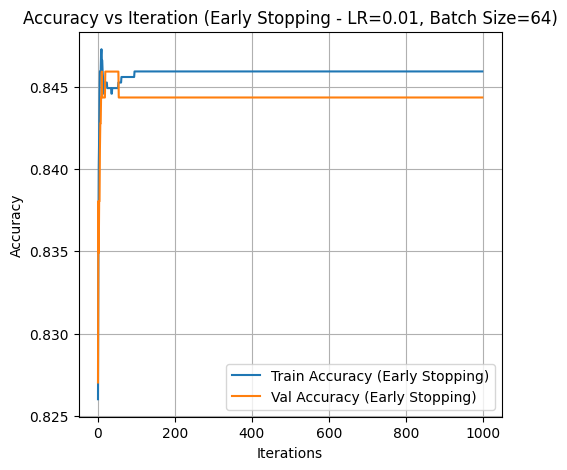

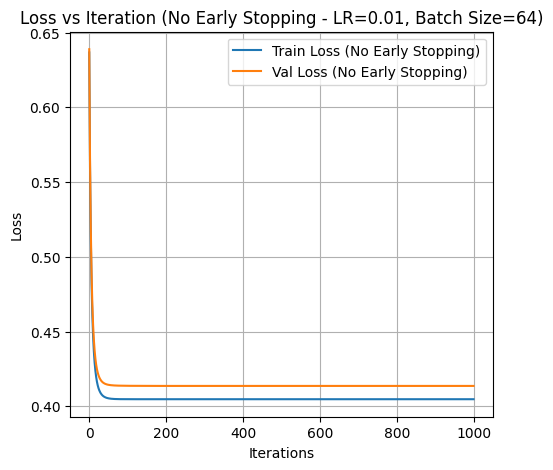

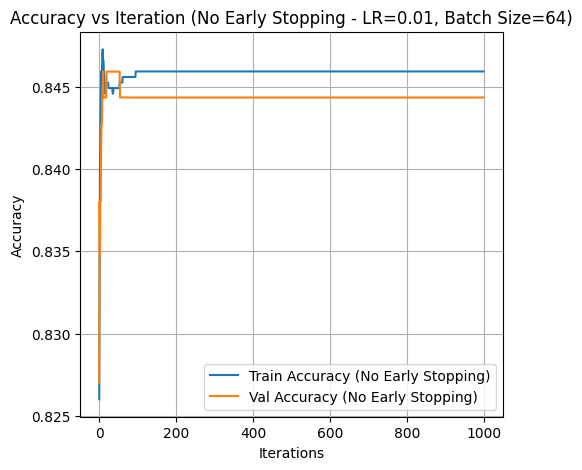

In [ ]:
import csv
import math
import random
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + math.exp(-min(max(z, -250), 250)))

def compute_loss(y_true, y_pred, weights, l1_reg=0.0, l2_reg=0.0):
    loss = 0
    for true, pred in zip(y_true, y_pred):
        loss += -(true * math.log(pred + 1e-7) + (1 - true) * math.log(1 - pred + 1e-7))
    loss /= len(y_true)

    if l1_reg > 0:
        loss += l1_reg * sum(abs(w) for w in weights)
    if l2_reg > 0:
        loss += 0.5 * l2_reg * sum(w ** 2 for w in weights)

    return loss

def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        random.seed(random_state)

    combined = list(zip(X, y))
    random.shuffle(combined)
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = combined[:split_idx], combined[split_idx:]
    return [x[0] for x in X_train], [x[0] for x in X_test], [x[1] for x in X_train], [x[1] for x in X_test]

def standard_scaler(X):
    mean = [sum(col) / len(col) for col in zip(*X)]
    std = [math.sqrt(sum((x - m) ** 2 for x in col) / len(col)) for col, m in zip(zip(*X), mean)]
    X_scaled = [
        [(x - m) / (s if s != 0 else 1) for x, m, s in zip(row, mean, std)]
        for row in X
    ]
    return X_scaled

def ensure_numeric(data):
    for row in data:
        for i in range(len(row)):
            if not isinstance(row[i], float):
                row[i] = float(row[i])

def gradient_descent(X_train, y_train, X_val, y_val, learning_rate=0.001, max_iter=1000, batch_size=64,
                     early_stopping_patience=31, l1_reg=0.0, l2_reg=0.0, min_iter_before_stopping=50):
    n_samples = len(X_train)
    n_features = len(X_train[0])
    weights = [0.0] * n_features
    bias = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    last_loss = float('inf')
    patience_counter = 0

    if early_stopping_patience == 0:
        early_stopping_patience = max_iter + 1

    for i in range(max_iter):
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]

            ensure_numeric(X_batch)

            y_predicted = [sigmoid(sum(w * x for w, x in zip(weights, row)) + bias) for row in X_batch]

            dw = [0.0] * n_features
            db = 0.0

            for j in range(n_features):
                gradient = sum((y_p - y_t) * row[j] for y_p, y_t, row in zip(y_predicted, y_batch, X_batch)) / len(y_batch)
                if l1_reg > 0:
                    gradient += l1_reg * (1 if weights[j] > 0 else -1)
                if l2_reg > 0:
                    gradient += l2_reg * weights[j]
                dw[j] = gradient

            db = sum(y_p - y_t for y_p, y_t in zip(y_predicted, y_batch)) / len(y_batch)

            weights = [w - learning_rate * d for w, d in zip(weights, dw)]
            bias -= learning_rate * db

        train_y_predicted = [sigmoid(sum(w * x for w, x in zip(weights, row)) + bias) for row in X_train]
        val_y_predicted = [sigmoid(sum(w * x for w, x in zip(weights, row)) + bias) for row in X_val]

        train_loss = compute_loss(y_train, train_y_predicted, weights, l1_reg, l2_reg)
        val_loss = compute_loss(y_val, val_y_predicted, weights, l1_reg, l2_reg)
        train_accuracy = sum((y_pred >= 0.5) == y_true for y_pred, y_true in zip(train_y_predicted, y_train)) / len(y_train)
        val_accuracy = sum((y_pred >= 0.5) == y_true for y_pred, y_true in zip(val_y_predicted, y_val)) / len(y_val)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        if i > min_iter_before_stopping and i > 0 and val_loss >= history['val_loss'][-2]:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at iteration {i}")
            break

        last_loss = train_loss

    return weights, bias, history

def predict(X, weights, bias, threshold=0.5):
    return [1 if sigmoid(sum(w * x for w, x in zip(weights, row)) + bias) >= threshold else 0 for row in X]

def load_csv(filename):
    data = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        headers = next(reader)
        for row in reader:
            processed_row = []
            for x in row:
                if x == 'NA' or x == '':
                    processed_row.append(None)
                else:
                    processed_row.append(float(x))
            data.append(processed_row)
    return data

def fill_missing_with_median(data):
    for col in range(len(data[0])):
        column_values = [row[col] for row in data if row[col] is not None]
        if column_values:
            sorted_col = sorted(column_values)
            mid = len(sorted_col) // 2
            if len(sorted_col) % 2 == 0:
                median = (sorted_col[mid - 1] + sorted_col[mid]) / 2
            else:
                median = sorted_col[mid]
            for row in data:
                if row[col] is None:
                    row[col] = median

data = load_csv('Heart Disease.csv')
fill_missing_with_median(data)
X = [row[:-1] for row in data]
y = [row[-1] for row in data]

X_standard = standard_scaler(X)

X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

learning_rates = [0.001, 0.01]
batch_sizes = [32, 64]
l1_reg = 0.01
l2_reg = 0.01

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with learning rate={lr} and batch size={batch_size}")

        weights, bias, history_early_stopping = gradient_descent(
            X_train, y_train, X_val, y_val,
            learning_rate=lr, max_iter=1000, batch_size=batch_size,
            early_stopping_patience=10, l1_reg=l1_reg, l2_reg=l2_reg, min_iter_before_stopping=50
        )

        weights_no_early_stopping, bias_no_early_stopping, history_no_early_stopping = gradient_descent(
            X_train, y_train, X_val, y_val,
            learning_rate=lr, max_iter=1000, batch_size=batch_size,
            early_stopping_patience=0, l1_reg=l1_reg, l2_reg=l2_reg, min_iter_before_stopping=50
        )

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history_early_stopping['train_loss'], label='Train Loss (Early Stopping)')
        plt.plot(history_early_stopping['val_loss'], label='Val Loss (Early Stopping)')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Loss vs Iteration (Early Stopping - LR={lr}, Batch Size={batch_size})')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history_early_stopping['train_accuracy'], label='Train Accuracy (Early Stopping)')
        plt.plot(history_early_stopping['val_accuracy'], label='Val Accuracy (Early Stopping)')
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs Iteration (Early Stopping - LR={lr}, Batch Size={batch_size})')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history_no_early_stopping['train_loss'], label='Train Loss (No Early Stopping)')
        plt.plot(history_no_early_stopping['val_loss'], label='Val Loss (No Early Stopping)')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Loss vs Iteration (No Early Stopping - LR={lr}, Batch Size={batch_size})')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history_no_early_stopping['train_accuracy'], label='Train Accuracy (No Early Stopping)')
        plt.plot(history_no_early_stopping['val_accuracy'], label='Val Accuracy (No Early Stopping)')
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs Iteration (No Early Stopping - LR={lr}, Batch Size={batch_size})')
        plt.legend()
        plt.grid(True)
        plt.show()
